# GCN for DAVIS 2016

In this notebook, a custom [PyTorch Geometric](https://rusty1s.github.io/pytorch_geometric/build/html/index.html) [InMemoryDataset](https://rusty1s.github.io/pytorch_geometric/build/html/_modules/torch_geometric/data/in_memory_dataset.html#InMemoryDataset) for the DAVIS 2016 dataset is created. The implementation is based on this [tutorial](https://rusty1s.github.io/pytorch_geometric/build/html/notes/create_dataset.html). The dataset is then used to train a simple GCN network as a first evaluation based on this [tutorial](https://rusty1s.github.io/pytorch_geometric/build/html/notes/introduction.html#learning-methods-on-graphs).

The dataset consists of single PyTorch Geometric [Data](https://rusty1s.github.io/pytorch_geometric/build/html/_modules/torch_geometric/data/data.html#Data) objects which model a single graph with various attributes. For this dataset, a graph for each contour is created. Hereby, each node of the graph represents one contour point. The feature of each node is the OSVOS feature vector from the next frame at this point. Each node is connected to its K nearest neighbours. The feature of each edge is the distance between the nodes it connects. The targets of each node is the translation it undergoes from the current to the next frame.

## Imports

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
from torch.utils.data.sampler import SequentialSampler

from torch_geometric.data import DataLoader

from pg_datasets.davis_2016 import DAVIS2016
from pg_networks.gcn import GCN
from pg_networks.sg import SG
from pg_networks.dynamic_edge import DynamicEdge
from pg_solvers.solver import Solver
from pg_utils.vis_utils import plot_img_with_contour_and_translation, plot_translations, plot_loss

from Combination_OSVOS_contour.final_prediction import compute_combo_img, plot_all

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


## Paths & Constants

In [3]:
PYTORCH_GEOMETRIC_DAVIS_2016_DATASET_PATH = 'pg_datasets/DAVIS_2016'#'pg_datasets/DAVIS_2016'
CONTOURS_FOLDERS_PATH = 'DAVIS_2016/DAVIS/Contours/480p'
IMAGES_FOLDERS_PATH = 'DAVIS_2016/DAVIS/JPEGImages/480p'
TRANSLATIONS_FOLDERS_PATH = 'DAVIS_2016/DAVIS/Translations/480p'

SKIP_SEQUENCES = []

SKIP_SEQUENCES = ['bmx-trees', 'bus', 'cows', 'dog-agility', 'horsejump-high', 
                 'horsejump-low', 'kite-walk', 'lucia', 'libby', 'motorbike',
                 'paragliding', 'rhino', 'scooter-gray', 'swing']

TRAIN_SEQUENCES = ['bear', 'bmx-bumps', 'boat', 'breakdance-flare', 'bus', 
                   'car-turn', 'dance-jump', 'dog-agility', 'drift-turn', 
                   'elephant', 'flamingo', 'hike', 'hockey', 'horsejump-low', 
                   'kite-walk', 'lucia', 'mallard-fly', 'mallard-water', 
                   'motocross-bumps', 'motorbike', 'paragliding', 'rhino', 
                   'rollerblade', 'scooter-gray', 'soccerball', 'stroller',
                   'surf', 'swing', 'tennis', 'train']

VAL_SEQUENCES = ['blackswan', 'bmx-trees', 'breakdance', 'camel', 'car-roundabout',
                 'car-shadow', 'cows', 'dance-twirl', 'dog', 'drift-chicane', 
                 'drift-straight', 'goat', 'horsejump-high', 'kite-surf', 'libby', 
                 'motocross-jump', 'paragliding-launch', 'parkour', 'scooter-black', 
                 'soapbox']

# Dataset parameters
EPOCHS_WO_AVEGRAD = 200
LAYER = 9
K = 32
NUM_SEQUENCES = 5

# Training parameters
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 0.0
NUM_EPOCHS = 50
EPOCHS_WO_AVEGRAD = 100

## Train and Val Dataset

In [4]:
train = DAVIS2016(PYTORCH_GEOMETRIC_DAVIS_2016_DATASET_PATH, 
                  CONTOURS_FOLDERS_PATH, IMAGES_FOLDERS_PATH, TRANSLATIONS_FOLDERS_PATH, 
                  LAYER, K, EPOCHS_WO_AVEGRAD,
                  SKIP_SEQUENCES, TRAIN_SEQUENCES[:NUM_SEQUENCES], VAL_SEQUENCES[:NUM_SEQUENCES],
                  train=True)

In [5]:
val = DAVIS2016(PYTORCH_GEOMETRIC_DAVIS_2016_DATASET_PATH, 
                CONTOURS_FOLDERS_PATH, IMAGES_FOLDERS_PATH, TRANSLATIONS_FOLDERS_PATH, 
                LAYER, K, EPOCHS_WO_AVEGRAD,
                SKIP_SEQUENCES, TRAIN_SEQUENCES[:NUM_SEQUENCES], VAL_SEQUENCES[:NUM_SEQUENCES],
                train=False)

In [6]:
print("Train size: %i" % len(train))
print("Val size: %i" % len(val))

Train size: 280
Val size: 291


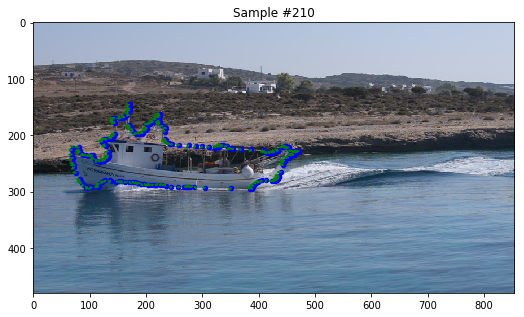

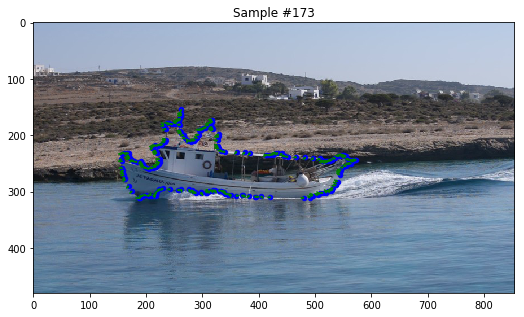

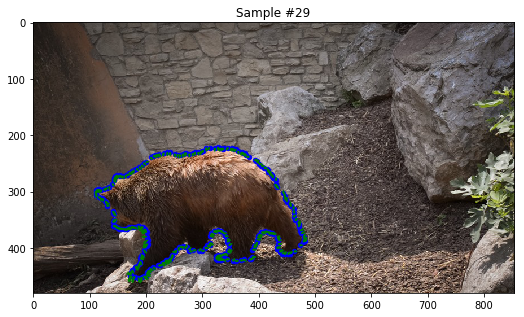

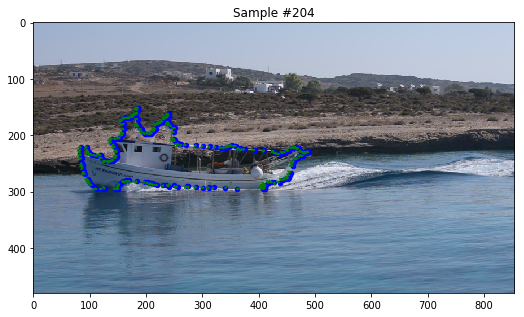

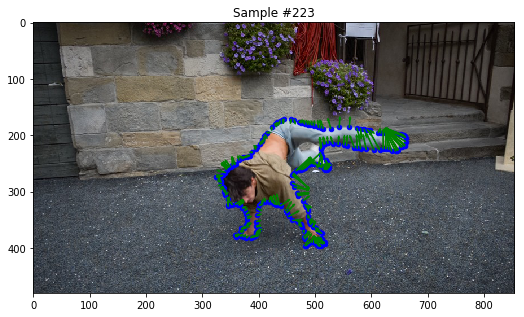

In [7]:
num_to_display = 5

for i in range(num_to_display):
    
    fig = plt.figure(figsize=(num_to_display*10,10))
    
    # randomly select a sample
    rand_i = np.random.randint(0, len(train))
    data = train[rand_i]
    
    ax = plt.subplot(1, num_to_display, i + 1)
    ax.set_title('Sample #{}'.format(rand_i))
    
    plot_img_with_contour_and_translation(data.img, data.contour, data.y)

## Simple GCN

In [8]:
model = GCN(in_channels=train[0].num_features, 
            out_channels=train[0].y.shape[1])

print(model)

GCN(
  (conv1): GCNConv(256, 512)
  (conv2): GCNConv(512, 512)
  (conv3): GCNConv(512, 1024)
  (lin1): Linear(in_features=1024, out_features=512, bias=True)
  (lin2): Linear(in_features=512, out_features=256, bias=True)
  (lin3): Linear(in_features=256, out_features=2, bias=True)
)


### Overfit

In [13]:
num_train = 80
num_val = 20

overfit_train_loader = DataLoader(train, batch_size=16, 
                                  shuffle=False, sampler=SequentialSampler(range(num_train)))
overfit_val_loader = DataLoader(train, batch_size=1, 
                                shuffle=False, sampler=SequentialSampler(range(num_val)))

# Load model and run the solver
overfit_model = GCN(in_channels=train[0].num_features, 
                    out_channels=train[0].y.shape[1])

overfit_solver = Solver(optim_args={"lr": LEARNING_RATE})
overfit_solver.train(overfit_model, overfit_train_loader, overfit_val_loader,
                     num_epochs=5, log_nth=100, verbose=True)

#Save model
torch.save(model.state_dict(), 'pg_models/Bear_overfit_model.pth')

START TRAIN.
[Epoch 1/5] trainloss: 108.27516 - val_loss: 10.80722
	L1 Loss: translation: 7.711191433052567 rounded: 7.707471021226999
	L2 Loss: translation: 108.2751616928061 rounded: 108.37844743154051
	L1 Loss:   Magnitude: 10.022670703457463 Angle: 68.68391014708615
	  -> rounded: Magnitude: 10.029155476560444 Angle: 68.68031873709683
	L2 Loss:   Magnitude: 170.05285330599017 Angle: 119.07789198543188
	  -> rounded: Magnitude: 170.25294898156994 Angle: 119.3936634753494
[Epoch 2/5] trainloss: 5.05994 - val_loss: 6.00351
	L1 Loss: translation: 1.616749756150638 rounded: 1.6025449593346401
	L2 Loss: translation: 5.059935308097792 rounded: 5.135882420675851
	L1 Loss:   Magnitude: 1.3546343804903318 Angle: 44.13505389887718
	  -> rounded: Magnitude: 1.350571828077218 Angle: 44.62479599263541
	L2 Loss:   Magnitude: 4.487623934129326 Angle: 55.339664843103684
	  -> rounded: Magnitude: 4.590357961484633 Angle: 59.79667794378465
[Epoch 3/5] trainloss: 4.28401 - val_loss: 4.79353
	L1 Loss: 

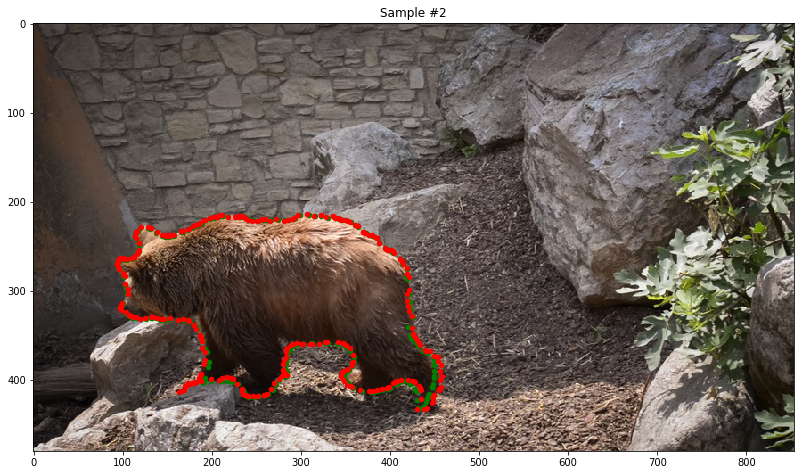

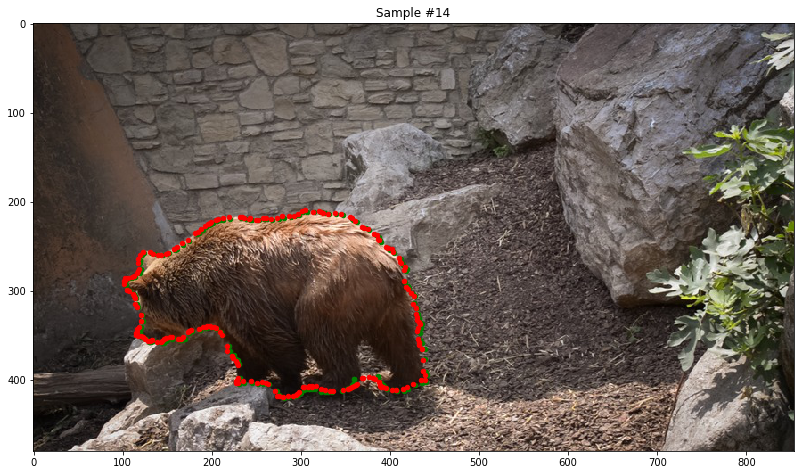

In [10]:
overfit_model.cpu()
overfit_model.double()
overfit_model.eval()
num_to_display = 2

for i in range(num_to_display):

    fig = plt.figure(figsize=(num_to_display*15,10))
    
    # randomly select a sample
    rand_i = np.random.randint(0, num_val)
    data = train[rand_i]
    
    with torch.no_grad():
        translation_pred = overfit_model(data)
        
    ax = plt.subplot(1, num_to_display, i + 1)
    ax.set_title('Sample #{}'.format(rand_i))
    
    plot_translations(data.img, data.contour, data.y, translation_pred)    

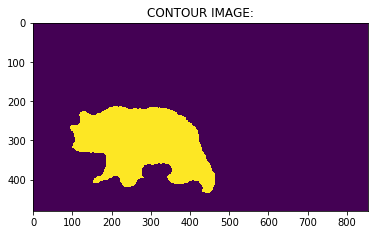

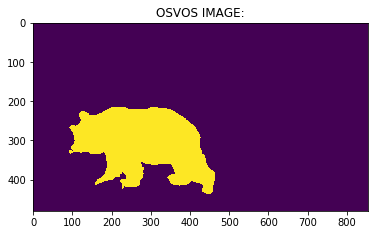

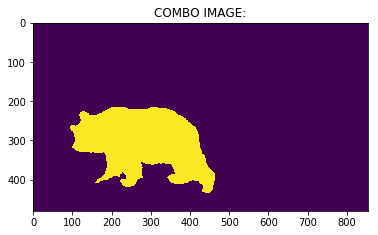

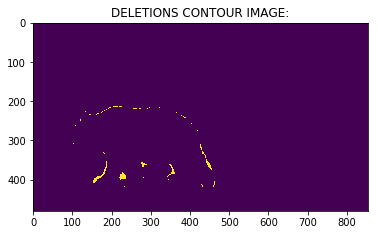

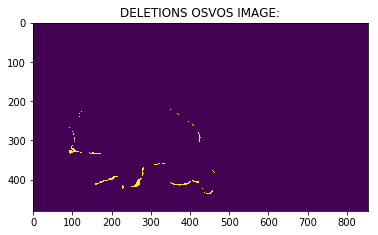

In [12]:
#Show test run for one example image
original_img = 'DAVIS_2016/DAVIS/JPEGImages/480p/bear/00001.png'
OSVOS_img = cv2.imread('OSVOS_PyTorch/models/Results/bear/00001.png')
old_contour = train[0].contour
translation_pred = overfit_model(train[0])
predicted_contour = old_contour.type(torch.DoubleTensor).add(translation_pred)

final_prediction = compute_combo_img(predicted_contour, OSVOS_img)
plot_all(predicted_contour, OSVOS_img)

### Train

In [ ]:
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val, batch_size=BATCH_SIZE, shuffle=False)

# Load model and run the solver
model = GCN(in_channels=train[0].num_features, 
            out_channels=train[0].y.shape[1])

solver = Solver(optim_args={"lr": LEARNING_RATE,
                            "weight_decay": WEIGHT_DECAY})

solver.train(model, train_loader, val_loader,
             num_epochs=NUM_EPOCHS, log_nth=100, verbose=True)

START TRAIN.
[Epoch 1/50] train_loss: 108.84180 - val_loss: 44.19436
[Epoch 2/50] train_loss: 51.48171 - val_loss: 44.20934
[Epoch 3/50] train_loss: 52.91746 - val_loss: 44.48213
[Epoch 4/50] train_loss: 45.90381 - val_loss: 44.46835
[Epoch 5/50] train_loss: 51.85138 - val_loss: 44.93575
[Epoch 6/50] train_loss: 44.38803 - val_loss: 44.84474
[Epoch 7/50] train_loss: 42.57795 - val_loss: 47.12229
[Epoch 8/50] train_loss: 41.00378 - val_loss: 48.75876
[Epoch 9/50] train_loss: 39.64478 - val_loss: 47.26976
[Epoch 10/50] train_loss: 42.91222 - val_loss: 51.27451
[Epoch 11/50] train_loss: 39.81902 - val_loss: 50.20098
[Epoch 12/50] train_loss: 35.15242 - val_loss: 53.65855
[Epoch 13/50] train_loss: 40.64722 - val_loss: 49.80863
[Epoch 14/50] train_loss: 38.78878 - val_loss: 51.45762
[Epoch 15/50] train_loss: 32.39685 - val_loss: 51.35353
[Epoch 16/50] train_loss: 32.96919 - val_loss: 54.78490
[Epoch 17/50] train_loss: 31.86706 - val_loss: 49.40273
[Epoch 18/50] train_loss: 29.47145 - val_lo

In [ ]:
plot_loss(solver)

### Display trained outputs

In [ ]:
model.cpu()
model.double()
model.eval()
num_to_display = 5

for i in range(num_to_display):

    fig = plt.figure(figsize=(num_to_display*15,10))
    
    # randomly select a sample
    rand_i = np.random.randint(0, len(val))
    data = val[rand_i]
    
    with torch.no_grad():
        translation_pred = model(data)
    
    ax = plt.subplot(1, num_to_display, i + 1)
    ax.set_title('Sample #{}'.format(rand_i))
    
    plot_translations(data.img, data.contour, data.y, translation_pred) 

### Hyperparameter Tuning

In [ ]:
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val, batch_size=BATCH_SIZE, shuffle=False)

learning_rates = [1e-2, 1e-4, 1e-6]
weight_decays = [1e-0, 1e-2, 1e-4]

best_model = None
best_loss = 1e10

i = 0
for learning_rate in learning_rates:
    for weight_decay in weight_decays:
        model = GCN(in_channels=train[0].num_features, 
                    out_channels=train[0].y.shape[1])
        solver = Solver(optim_args={"lr": LEARNING_RATE,
                            "weight_decay": WEIGHT_DECAY})
        solver.train(model, train_loader, val_loader,
             num_epochs=20, log_nth=100, verbose=False)

        # Predict on the validation set
        val_loss = max(solver.val_loss_history)
        print('Hyperparamter Tuning #', i + 1,
                'lr: ', learning_rate,
                'wd: ', weight_decay,
                'val_loss: ', val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model

        i += 1